In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# We dont need this since sentiment is already available
# # 1. Data Preparation
# def prepare_data(df):
#     # Create sentiment labels based on Reviewer_Score
#     df['sentiment'] = df['Reviewer_Score'].apply(
#         lambda x: 'positive' if x >= 7.0 else 'negative'
#     )
    
#     # Group by aspects
#     aspects = df['aspect_label'].unique()
    
#     return df, aspects

In [9]:
# 2. Train SVM models for each aspect
def train_aspect_models(df, aspects):
    models = {}
    results = {}
    
    for aspect in aspects:
        print(f"\nTraining model for aspect: {aspect}")
        
        # Filter data for current aspect
        aspect_data = df[df['aspect_label'] == aspect]
        
        if len(aspect_data) < 2:
            print(f"Insufficient data for aspect: {aspect}")
            continue
            
        # Create pipeline
        model = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=1000)),
            ('svm', SVC(kernel='linear', probability=True))
        ])
        
        # Split data
        X = aspect_data['processed_text']
        y = aspect_data['review_type']
        
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predictions
            y_pred = model.predict(X_test)
            
            # Store results
            results[aspect] = {
                'classification_report': classification_report(y_test, y_pred, output_dict=True),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'test_data': (X_test, y_test),
                'predictions': y_pred
            }
            
            models[aspect] = model
            
        except Exception as e:
            print(f"Error training model for aspect {aspect}: {str(e)}")
            continue
    
    return models, results

In [10]:
# 3. Error Analysis
def perform_error_analysis(df, results):
    error_analysis = {}
    
    for aspect, result in results.items():
        X_test, y_test = result['test_data']
        y_pred = result['predictions']
        
        # Find misclassified samples
        misclassified_idx = np.where(y_test != y_pred)[0]
        
        error_analysis[aspect] = {
            'misclassified_samples': [],
            'common_terms': []
        }
        
        for idx in misclassified_idx:
            error_analysis[aspect]['misclassified_samples'].append({
                'text': X_test.iloc[idx],
                'true_sentiment': y_test.iloc[idx],
                'predicted_sentiment': y_pred[idx]
            })
    
    return error_analysis

# 4. Visualization
def plot_results(results):
    fig, axes = plt.subplots(len(results), 2, figsize=(15, 5*len(results)))
    
    for i, (aspect, result) in enumerate(results.items()):
        # Plot confusion matrix
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', ax=axes[i, 0])
        axes[i, 0].set_title(f'Confusion Matrix - {aspect}')
        
        # Plot metrics
        metrics = result['classification_report']
        metrics_df = pd.DataFrame({
            'Precision': [metrics[label]['precision'] for label in ['positive', 'negative']],
            'Recall': [metrics[label]['recall'] for label in ['positive', 'negative']],
            'F1-score': [metrics[label]['f1-score'] for label in ['positive', 'negative']]
        }, index=['Positive', 'Negative'])
        
        metrics_df.plot(kind='bar', ax=axes[i, 1])
        axes[i, 1].set_title(f'Metrics - {aspect}')
        axes[i, 1].set_ylim([0, 1])
    
    plt.tight_layout()
    return fig

In [11]:
input_file_path = "../data/processed/hotel_reviews_aspects.csv"


Training model for aspect: room
Error training model for aspect room: np.nan is an invalid document, expected byte or unicode string.

Training model for aspect: location


d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Training model for aspect: staff


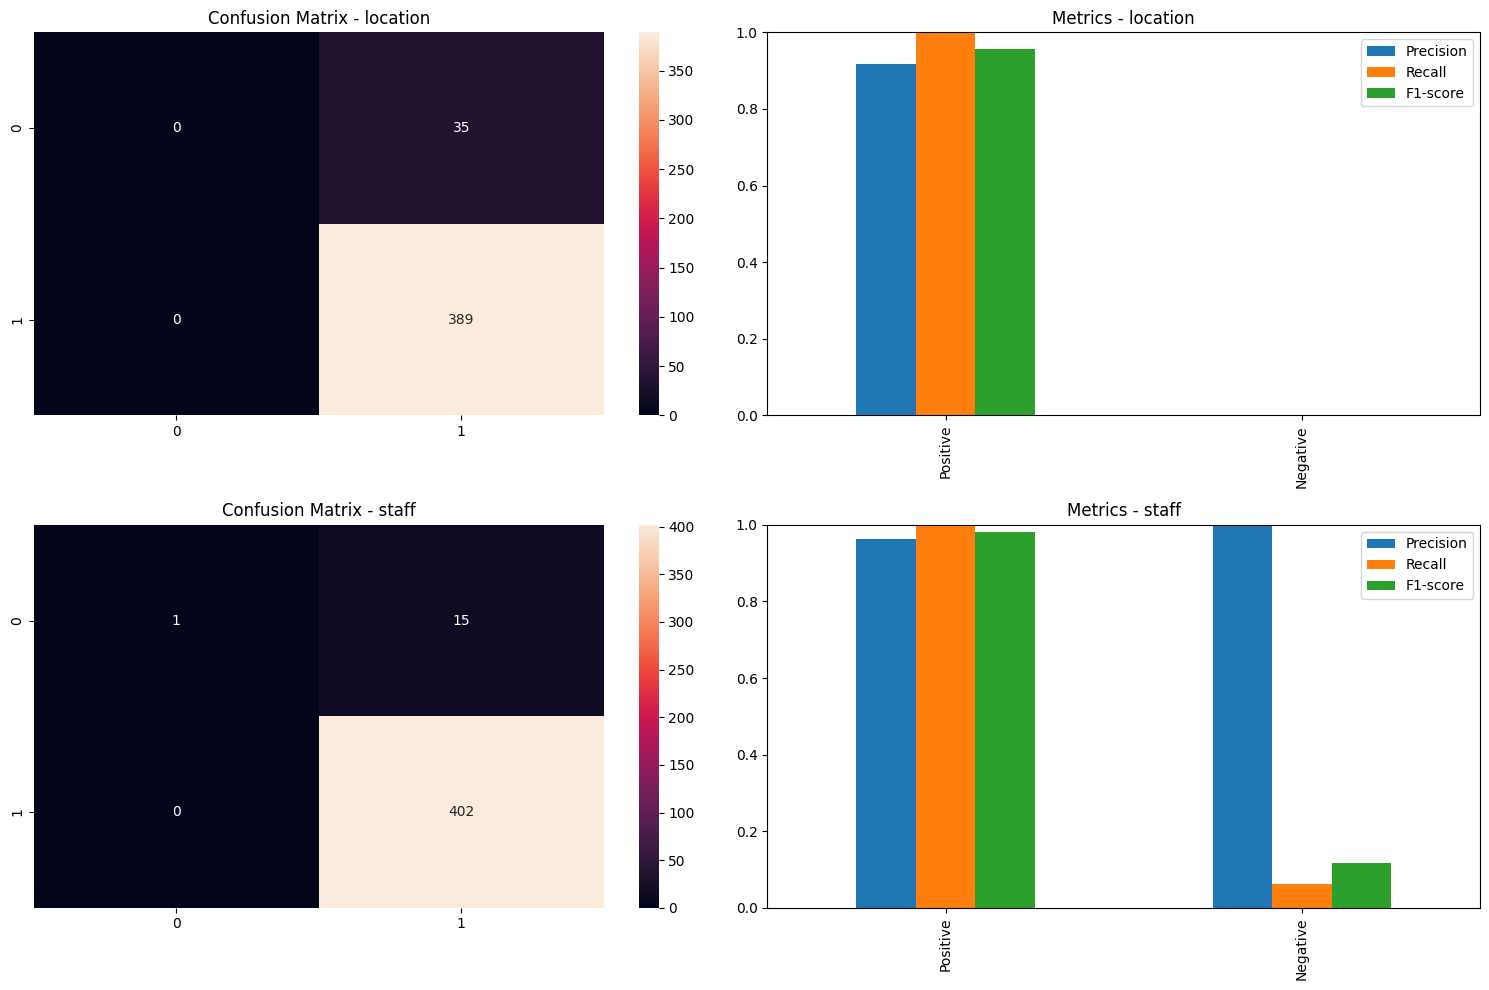

In [14]:
# Load and prepare data
prepared_df = pd.read_csv(input_file_path)
aspects = prepared_df['aspect_label'].unique()

# Train models
models, results = train_aspect_models(prepared_df, aspects)

# Perform error analysis
error_analysis = perform_error_analysis(prepared_df, results)

# Plot results
plot = plot_results(results)
plt.show()


In [15]:
# Print results
for aspect, result in results.items():
    print(f"\nResults for aspect: {aspect}")
    print("\nClassification Report:")
    print(classification_report(
        result['test_data'][1],
        result['predictions']
    ))
    
    print("\nError Analysis:")
    for error in error_analysis[aspect]['misclassified_samples'][:3]:
        print(f"\nText: {error['text']}")
        print(f"True sentiment: {error['true_sentiment']}")
        print(f"Predicted sentiment: {error['predicted_sentiment']}")



Results for aspect: location

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        35
    positive       0.92      1.00      0.96       389

    accuracy                           0.92       424
   macro avg       0.46      0.50      0.48       424
weighted avg       0.84      0.92      0.88       424


Error Analysis:

Text: room tiny good value money room fantastic hotel
True sentiment: negative
Predicted sentiment: positive

Text: good
True sentiment: negative
Predicted sentiment: positive

Text: location
True sentiment: negative
Predicted sentiment: positive

Results for aspect: staff

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.06      0.12        16
    positive       0.96      1.00      0.98       402

    accuracy                           0.96       418
   macro avg       0.98      0.53      0.55       418
weighted avg       0.97      0.

d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Lumini\IR Q2\clustering-classification\cluster_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Main execution
def main(data):
    # Load and prepare data
    prepared_df = pd.read_csv(input_file_path)
    aspects = prepared_df['aspect_label'].unique()
    
    # Train models
    models, results = train_aspect_models(prepared_df, aspects)
    
    # Perform error analysis
    error_analysis = perform_error_analysis(prepared_df, results)
    
    # Plot results
    plot = plot_results(results)
    
    return models, results, error_analysis, plot

# Run the analysis
models, results, error_analysis, plot = main('your_data.csv')

# Print results
for aspect, result in results.items():
    print(f"\nResults for aspect: {aspect}")
    print("\nClassification Report:")
    print(classification_report(
        result['test_data'][1],
        result['predictions']
    ))
    
    print("\nError Analysis:")
    for error in error_analysis[aspect]['misclassified_samples'][:3]:
        print(f"\nText: {error['text']}")
        print(f"True sentiment: {error['true_sentiment']}")
        print(f"Predicted sentiment: {error['predicted_sentiment']}")

plt.show()